In [3]:
# !pip install torch torchvision
# !pip install git+https://github.com/facebookresearch/segment-anything.git
# !pip install tabulate


import numpy as np
import PIL
from PIL import Image
import torch
import os
import matplotlib.pyplot as plt
import cv2

from tabulate import tabulate
from scipy.stats import skew, kurtosis, kstest, jarque_bera, ttest_rel, wilcoxon, levene
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from google.colab import files
from scipy import stats

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

from google.colab import drive
drive.mount('/content/drive/')

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-61cpv88a
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-61cpv88a
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=6daf256f5972fadb4e8ee95218465f5508d40a9336cc54a6275986669e1496d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-x9qqwdxy/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
Mounted at /content/drive/


# Implementación de SAM


In [4]:
path = "/content/drive/My Drive/TEC - Modulo III/Tarea 02/"
print("CUDA is available:", torch.cuda.is_available())

CUDA is available: True


In [5]:

sam_checkpoint = "/content/drive/My Drive/TEC - Modulo III/Tarea 02/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [6]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100
)

In [7]:
image = cv2.imread('/content/drive/My Drive/TEC - Modulo III/Tarea 02/DATASET_GLIOBLASTOMA/Original/C4_02_1_1_DAPI_001.png')
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(image)

In [18]:
# Aca se hace una modificacion al codigo brindado por Meta AI, por que en
# nuestro caso necesitamos segmentar las celulas de forma binarizada
# blanco o negro (1 o 0), y el codigo de Meta lo que hace es que asigna un color
# aleatorio a cada elemento que segmente. O sea, este modelo no distingue que es
# una celula y que no, mas bien distingue cada objeto segmentable.
# Entonces para adaptar este modelo a nuestras necesidades se convierte el fondo
# en color negro y todo elemento que no sea el fondo en blanco.
# esto se puede hacer por que el modelo nos da una lista de cada segmentacion
# ordenada por el area, por lo que el objeto con mayor área es el primero en la
# lista, en nuestro caso es el fondo, por lo que al primer elemento se le asgina
# el color negro y a todos los demás el blanco

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)

    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0

    cont = 0

    for ann in sorted_anns:
        cont += 1
        m = ann['segmentation']

        if cont == 1:  # Si es el primer ann
            color_mask = np.array([0, 0, 0, 1])  # Color negro con opacidad total
        else:
            color_mask = np.array([1, 1, 1, 1])

        img[m] = color_mask
    ax.imshow(img)

    return img


In [16]:
def show_anns_original(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

(409, 452)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

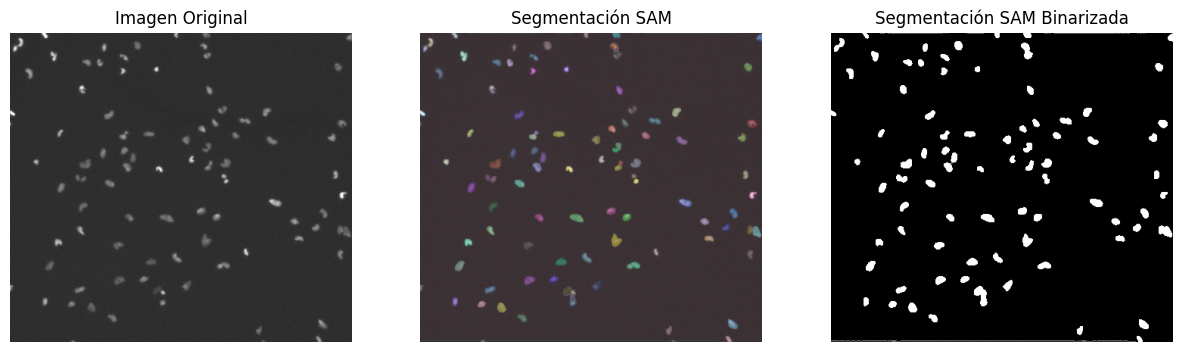

In [19]:
plt.figure(figsize=(15, 5))  # Aumenta el tamaño para acomodar ambas imágenes

#Imagen origi
plt.subplot(1, 3, 1)  # 1 fila, 2 columnas, primer subplot
plt.imshow(image)
plt.title("Imagen Original")
plt.axis('off')

# Muestra la imagen original
plt.subplot(1, 3, 2)  # 1 fila, 2 columnas, primer subplot
plt.imshow(image)
show_anns_original(masks)
plt.title("Segmentación SAM")
plt.axis('off')


# Muestra la imagen de SAM
plt.subplot(1, 3, 3)  # 1 fila, 2 columnas, segundo subplot
plt.imshow(image)
img = show_anns(masks)
plt.title("Segmentación SAM Binarizada")
plt.axis('off')

# plt.imshow(U_sam, cmap='gray')  # U_sam es en escala de grises
# plt.title("SAM Image")
# plt.axis('off')

img_float32 = img.astype(np.float32)

U_sam = cv2.cvtColor(img_float32, cv2.COLOR_RGBA2GRAY)
print(U_sam.shape)

U_sam = torch.from_numpy(U_sam)

plt.savefig('implementacion_sam.png')

# Descargar la imagen
files.download('implementacion_sam.png')

plt.show()


# Implementacion Kittler

In [7]:
def calculate_histo(M):
    u, c= torch.unique(M, return_counts=True)
    return u, c/torch.numel(M)

In [8]:
def calcular_momentos_estadisticos(t,H):

    i = torch.searchsorted(H[0], t, right=True) - 1
    p1 = torch.sum(H[1][:i+1])
    mu1 = torch.sum(H[0][:i]*H[1][:i])/p1
    sig1 = torch.sum(H[1][:i]*(H[0][:i]-mu1)**2)/p1

    p2 = 1 - p1
    mu2 = torch.sum(H[0][i: 255]*H[1][i:255])/p2
    sig2 = torch.sum(H[1][i: 255]*(H[0][i: 255]-mu2)**2)/p2

    return p1,mu1,sig1,p2,mu2,sig2

In [9]:
def calculate_cost_J(T, H):
    p1,mu1,sig1,p2,mu2,sig2 = calcular_momentos_estadisticos(T, H)
    return 1 + 2*(p1*np.log(sig1) + p2*np.log(sig2))-2*(p1*np.log(p1) + p2*np.log(p2))

In [14]:
def kittler(U):

    H = calculate_histo(U)
    c = []

    for i in range(256):
        c.append(calculate_cost_J(i,H))

    t_costos = torch.tensor(c)
    t_costos = torch.where(torch.isinf(t_costos), float('inf'), t_costos)
    t_costos[torch.isnan(t_costos)] = float('inf')

    min_costo = torch.min(t_costos)
    tao = torch.argmin(t_costos)

    U_umbra = torch.where(U > tao, torch.tensor(1), torch.tensor(0))

    return U_umbra

<ipython-input-9-6ef711f243ba>:3: RuntimeWarning: divide by zero encountered in log
  return 1 + 2*(p1*np.log(sig1) + p2*np.log(sig2))-2*(p1*np.log(p1) + p2*np.log(p2))


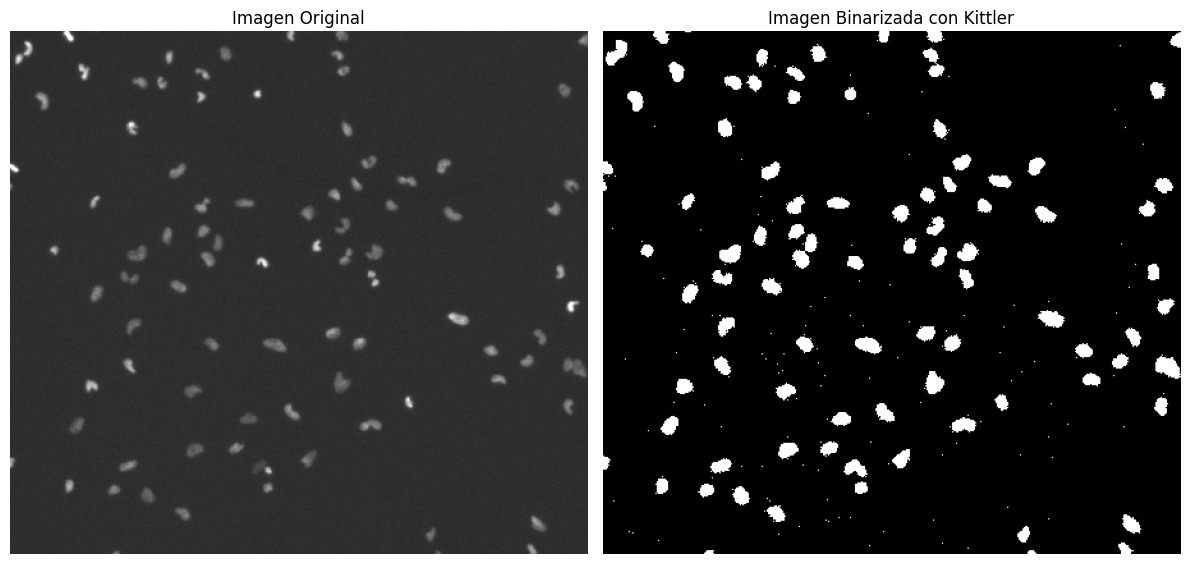

In [15]:
U_kittler_original = cv2.imread(path +'DATASET_GLIOBLASTOMA/Original/C4_02_1_1_DAPI_001.png')
U_kittler = cv2.imread(path +'DATASET_GLIOBLASTOMA/Original/C4_02_1_1_DAPI_001.png', cv2.IMREAD_GRAYSCALE)

U_kittler = kittler(torch.tensor(U_kittler))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(U_kittler_original)
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(U_kittler, cmap='gray')
plt.title('Imagen Binarizada con Kittler')
plt.axis('off')

plt.tight_layout()
plt.show()



# Implementación de Referencia

Para calcular la métrica de dice, se utiliza como referencia la segmentación de las imagenes de la carpeta **Groundtruth**. Para las cuales se cargan en una escala de grises y luego se binarizan con un umbral obtenido por el **método de Otzu**.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

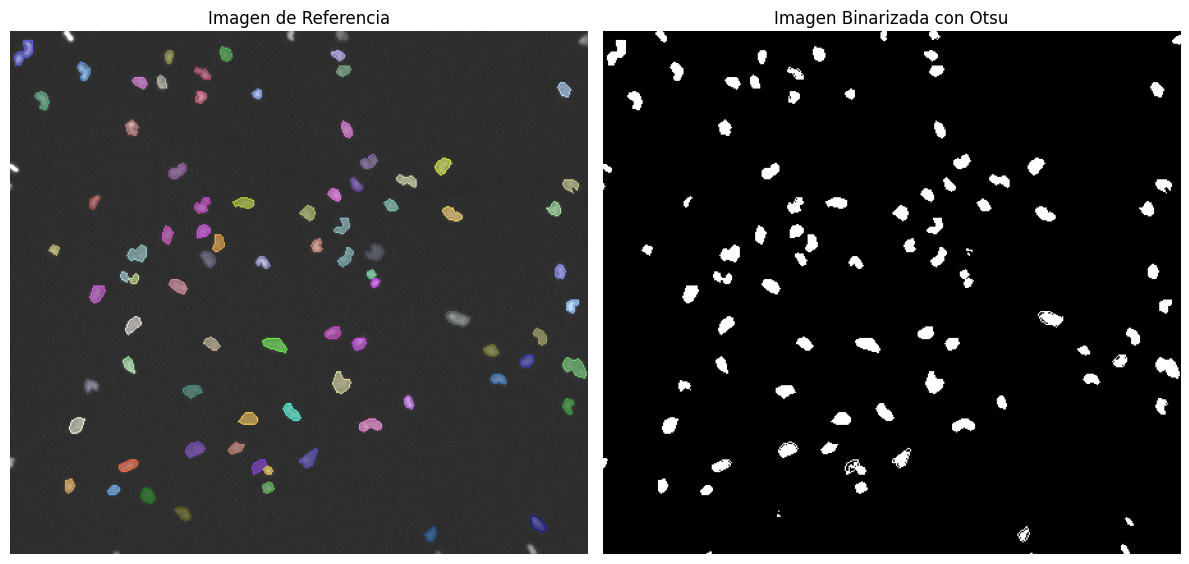

In [10]:
U_ref_origin = cv2.imread(path+"DATASET_GLIOBLASTOMA/Groundtruth/C4_02_1_1_DAPI_001_overlay.png")
U_ref = cv2.imread(path+"DATASET_GLIOBLASTOMA/Groundtruth/C4_02_1_1_DAPI_001_overlay.png",  cv2.IMREAD_GRAYSCALE)

_, U_ref = cv2.threshold(U_ref, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

U_ref = U_ref / 255
U_ref = torch.from_numpy(U_ref)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(U_ref_origin)
plt.title('Imagen de Referencia')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(U_ref, cmap='gray')
plt.title('Imagen Binarizada con Otsu')
plt.axis('off')

plt.tight_layout()
plt.savefig('otzu.png')

files.download('otzu.png')
plt.show()




# Implementación de métrica DICE



In [11]:
def dice_metric(y_ref, y_pred):
    intersec = torch.sum(y_ref * y_pred)
    return (2. * intersec) / (torch.sum(y_ref) + torch.sum(y_pred))

In [45]:
dice_SAM = dice_metric(U_ref, U_sam)
dice_Kittler = dice_metric(U_ref, U_kittler)

print("Dice para SAM", dice_SAM)
print("Dice para Kittler", dice_Kittler)

Dice para SAM tensor(0.7928, dtype=torch.float64)
Dice para Kittler tensor(0.8222, dtype=torch.float64)


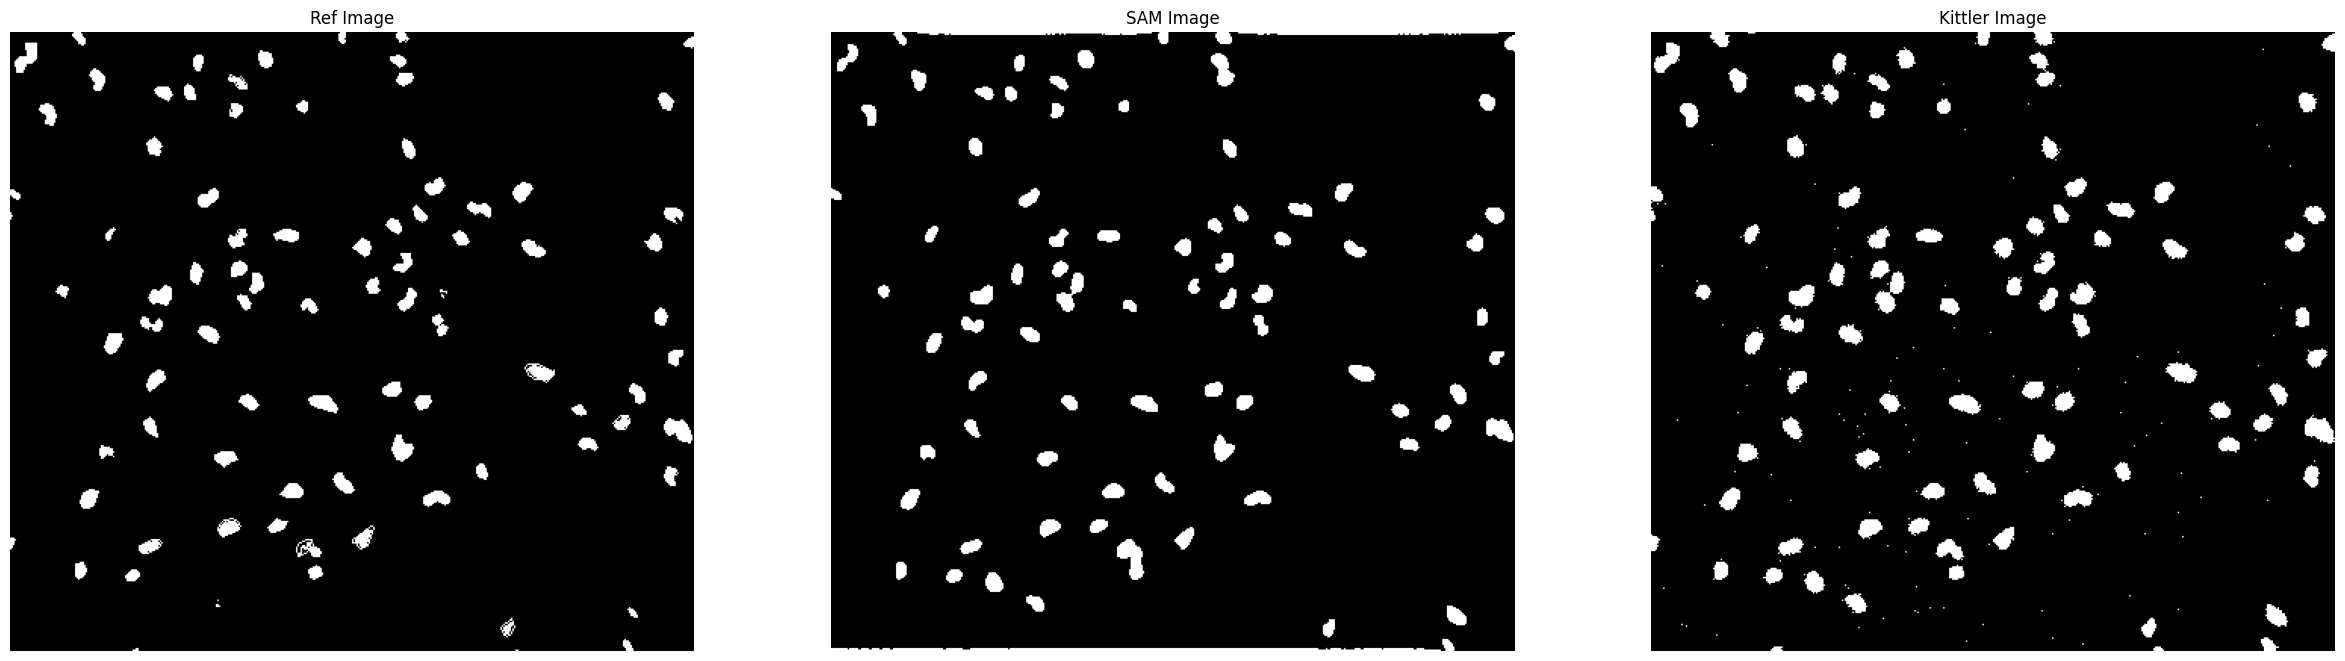

In [ ]:
plt.figure(figsize=(30, 10))
# Segmentacion de Referencia
plt.subplot(1, 3, 1)  # 1 fila, 3 columnas, primer subplot
plt.imshow(U_ref, cmap='gray')
plt.title("Ref Image")
plt.axis('off')

# Segmentacion SAM
plt.subplot(1, 3, 2)  # 1 fila, 3 columnas, segundo subplot
plt.imshow(U_sam, cmap='gray')  # U_sam es en escala de grises
plt.title("SAM Image")
plt.axis('off')

# Segmentacion Kittler
plt.subplot(1, 3, 3)  # 1 fila, 3 columnas, tercer subplot
plt.imshow(U_kittler.numpy(), cmap='gray')  # U_kittler es en escala de grises
plt.title("Kittler Image")
plt.axis('off')

plt.show()

# Pruebas Unitaria para Métrica de Dice

1. Se calcula la metrica de dice para una misma imagen usada en referencia y en el modelo, aca se espera que el resultados sea mediantamente alto

2. Se utilizan dos imagenes diferentes para cada modelo, en este caso la metrica deberia de ser pequeño

In [24]:
# Se utilizaran estas dos imagenes: 'C4_02_1_1_DAPI_200.png', 'D4_02_1_1_DAPI_001.png'
path_test = path + "DATASET_GLIOBLASTOMA/Original/"
path_ref = path + "DATASET_GLIOBLASTOMA/Groundtruth/"

# Prueba 1
U_kittler_unit = kittler(path_test+"C4_02_1_1_DAPI_200.png")
U_ref_unit = ref(path_ref+"C4_02_1_1_DAPI_200_overlay.png")
print("Metrica de Dice entre misma imagenes: ", dice_metric(U_ref_unit, U_kittler_unit))


# Prueba 2
U_kittler_unit = kittler(path_test+"C4_02_1_1_DAPI_200.png")
U_ref_unit = ref(path_ref+"D4_02_1_1_DAPI_001_overlay.png")
print("Metrica de Dice entre imagenes diferentes: ", dice_metric(U_ref_unit, U_kittler_unit))



Metrica de Dice entre misma imagenes:  tensor(0.6959, dtype=torch.float64)
Metrica de Dice entre imagenes diferentes:  tensor(0.0745, dtype=torch.float64)


# Segmentación de las Imagenes y calculo de Dice

Se procede a calcular la metrica de dice para SAM y Kittler para cada partición.
Son 30 particiones diferentes, entonces se procede a calcular la media de la de
la metrica de dice para cada particion

In [17]:
def kittler(path):
    U = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    U = torch.tensor(U)

    H = calculate_histo(U)
    c = []

    for i in range(256):
        c.append(calculate_cost_J(i,H))

    t_costos = torch.tensor(c)
    t_costos = torch.where(torch.isinf(t_costos), float('inf'), t_costos)
    t_costos[torch.isnan(t_costos)] = float('inf')

    min_costo = torch.min(t_costos)
    tao = torch.argmin(t_costos)

    U_umbra = torch.where(U > tao, torch.tensor(1), torch.tensor(0))

    return U_umbra


In [18]:
def sam(path):
  image = cv2.imread(path)
  image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  masks = mask_generator.generate(image)
  img = show_anns(masks)
  img_float32 = img.astype(np.float32)

  U_sam = cv2.cvtColor(img_float32, cv2.COLOR_RGBA2GRAY)
  U_sam = torch.from_numpy(U_sam)

  return U_sam

In [20]:
def ref(path):
  U_ref = cv2.imread(path,  cv2.IMREAD_GRAYSCALE)
  _, U_ref = cv2.threshold(U_ref, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  U_ref = U_ref / 255
  U_ref = torch.from_numpy(U_ref)
  return U_ref

In [8]:
path_test = path + "DATASET_GLIOBLASTOMA/Original/"
path_ref = path + "DATASET_GLIOBLASTOMA/Groundtruth/"

all_images = [f for f in os.listdir(path_test) if os.path.isfile(os.path.join(path_test, f))]

partitions = []

for _ in range(30):
  sample_img = np.random.choice(all_images, 5, replace=True).tolist()
  partitions.append(sample_img)

for i, partition in enumerate(partitions, 1):
   print(f"Partition {i}: {partition}")

Partition 1: ['C4_02_1_1_DAPI_001.png', 'C4_02_1_1_DAPI_577.png', 'C4_02_1_1_DAPI_200.png', 'C4_02_1_1_DAPI_577.png', 'D4_02_1_1_DAPI_577.png']
Partition 2: ['C4_02_1_1_DAPI_289.png', 'D4_02_1_1_DAPI_145.png', 'D4_02_1_1_DAPI_289.png', 'D4_02_1_1_DAPI_433.png', 'D4_02_1_1_DAPI_289.png']
Partition 3: ['C4_02_1_1_DAPI_289.png', 'C4_02_1_1_DAPI_289.png', 'C4_02_1_1_DAPI_289.png', 'C4_02_1_1_DAPI_289.png', 'D4_02_1_1_DAPI_433.png']
Partition 4: ['C4_02_1_1_DAPI_433.png', 'C4_02_1_1_DAPI_145.png', 'C4_02_1_1_DAPI_289.png', 'C4_02_1_1_DAPI_200.png', 'C4_02_1_1_DAPI_433.png']
Partition 5: ['C4_02_1_1_DAPI_433.png', 'D4_02_1_1_DAPI_001.png', 'D4_02_1_1_DAPI_145.png', 'C4_02_1_1_DAPI_289.png', 'C4_02_1_1_DAPI_001.png']
Partition 6: ['D4_02_1_1_DAPI_289.png', 'C4_02_1_1_DAPI_145.png', 'D4_02_1_1_DAPI_001.png', 'C4_02_1_1_DAPI_433.png', 'C4_02_1_1_DAPI_145.png']
Partition 7: ['C4_02_1_1_DAPI_145.png', 'D4_02_1_1_DAPI_577.png', 'C4_02_1_1_DAPI_145.png', 'D4_02_1_1_DAPI_001.png', 'C4_02_1_1_DAPI_25

<ipython-input-10-6ef711f243ba>:3: RuntimeWarning: divide by zero encountered in log
  return 1 + 2*(p1*np.log(sig1) + p2*np.log(sig2))-2*(p1*np.log(p1) + p2*np.log(p2))
<ipython-input-10-6ef711f243ba>:3: RuntimeWarning: invalid value encountered in log
  return 1 + 2*(p1*np.log(sig1) + p2*np.log(sig2))-2*(p1*np.log(p1) + p2*np.log(p2))


CPU times: user 54min 5s, sys: 23.4 s, total: 54min 28s
Wall time: 54min 9s


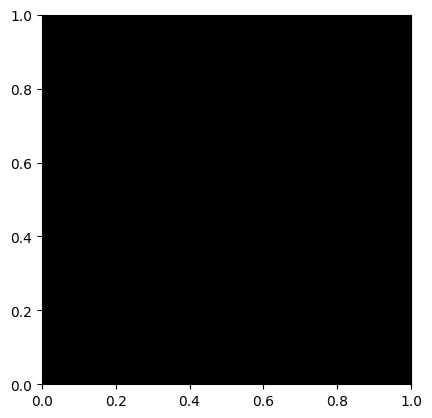

In [ ]:
%%time

dice_sam = []
dice_kittler = []

for partition in partitions:
  kittler_results = []
  sam_results = []

  for image in partition:
    img_path_test = os.path.join(path_test, image)
    image = image[:-4] + '_overlay.png'
    img_path_ref = os.path.join(path_ref, image)

    # Se segmentan las imagenes
    kittler_res = kittler(img_path_test)
    sam_res = sam(img_path_test)
    ref_res = ref(img_path_ref) # arreglar path ref

    # se guardan los resultados
    kittler_results.append(dice_metric(kittler_res, ref_res))
    sam_results.append(dice_metric(sam_res, ref_res))

  dice_kittler.append(sum(kittler_results)/len(kittler_results))
  dice_sam.append(sum(sam_results)/len(sam_results))

In [ ]:
# print(dice_kittler)
# print(dice_sam)

# for d in range(len(dice_kittler)):
#   print(str(d)+". Kittler: "+str(dice_kittler[d].item())+"  SAM: "+str(dice_sam[d].item()))

table_data = list(zip(range(1, len(dice_sam)+1), dice_sam, dice_kittler))
headers = ["Index", "Dice SAM", "Dice Kittler"]
latex_table = tabulate(table_data, headers=headers, tablefmt="latex_booktabs")
print(latex_table)

\begin{tabular}{rrr}
\toprule
   Index &   Dice SAM &   Dice Kittler \\
\midrule
       1 &   0.694371 &       0.675576 \\
       2 &   0.693059 &       0.703058 \\
       3 &   0.660477 &       0.67644  \\
       4 &   0.688064 &       0.701478 \\
       5 &   0.682801 &       0.702788 \\
       6 &   0.669525 &       0.663236 \\
       7 &   0.724576 &       0.712842 \\
       8 &   0.570872 &       0.581286 \\
       9 &   0.71347  &       0.718948 \\
      10 &   0.65389  &       0.654639 \\
      11 &   0.752402 &       0.688062 \\
      12 &   0.688185 &       0.717254 \\
      13 &   0.703395 &       0.725251 \\
      14 &   0.692903 &       0.695933 \\
      15 &   0.739955 &       0.744255 \\
      16 &   0.744122 &       0.71283  \\
      17 &   0.728762 &       0.756573 \\
      18 &   0.693567 &       0.724279 \\
      19 &   0.715176 &       0.707666 \\
      20 &   0.520495 &       0.565657 \\
      21 &   0.70444  &       0.719686 \\
      22 &   0.687995 &       0.71582

In [ ]:

# SAM
media_sam = np.mean(dice_sam)
mediana_sam = np.median(dice_sam)
std_sam = np.std(dice_sam)
inclinacion_sam = skew(dice_sam)
kurtosis_sam = kurtosis(dice_sam, fisher=True)  # Si fisher=True, la kurtosis se calcula como kurtosis normal - 3.

# Kittler
media_kittler = np.mean(dice_kittler)
mediana_kittler = np.median(dice_kittler)
std_kittler = np.std(dice_kittler)
inclinacion_kittler = skew(dice_kittler)
kurtosis_kittler = kurtosis(dice_kittler, fisher=True)

print("Para SAM:")
print(f"Media: {media_sam}")
print(f"Mediana: {mediana_sam}")
print(f"Desviación estándar: {std_sam}")
print(f"Inclinación: {inclinacion_sam}")
print(f"Kurtosis: {kurtosis_sam}")

print("\nPara Kittler:")
print(f"Media: {media_kittler}")
print(f"Mediana: {mediana_kittler}")
print(f"Desviación estándar: {std_kittler}")
print(f"Inclinación: {inclinacion_kittler}")
print(f"Kurtosis: {kurtosis_kittler}")

Para SAM:
Media: 0.6944905826371417
Mediana: 0.6988830295955866
Desviación estándar: 0.048257558526521686
Inclinación: -1.9081202147636307
Kurtosis: 4.392693538571604

Para Kittler:
Media: 0.7017211208649172
Mediana: 0.71192525816131
Desviación estándar: 0.04250235841101854
Inclinación: -1.6389051935024537
Kurtosis: 3.0791709840812453


In [ ]:
headers = ["Métrica", "SAM", "Kittler"]
table = [
    ["Media", media_sam, media_kittler],
    ["Mediana", mediana_sam, mediana_kittler],
    ["Desviación Estándar", std_sam, std_kittler],
    ["Inclinación", inclinacion_sam, inclinacion_kittler],
    ["Kurtosis", kurtosis_sam, kurtosis_kittler]
]

latex_table = tabulate(table, headers=headers, tablefmt="latex")

print(latex_table)

\begin{tabular}{lrr}
\hline
 Métrica             &        SAM &    Kittler \\
\hline
 Media               &  0.694491  &  0.701721  \\
 Mediana             &  0.698883  &  0.711925  \\
 Desviación Estándar &  0.0482576 &  0.0425024 \\
 Inclinación         & -1.90812   & -1.63891   \\
 Kurtosis            &  4.39269   &  3.07917   \\
\hline
\end{tabular}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

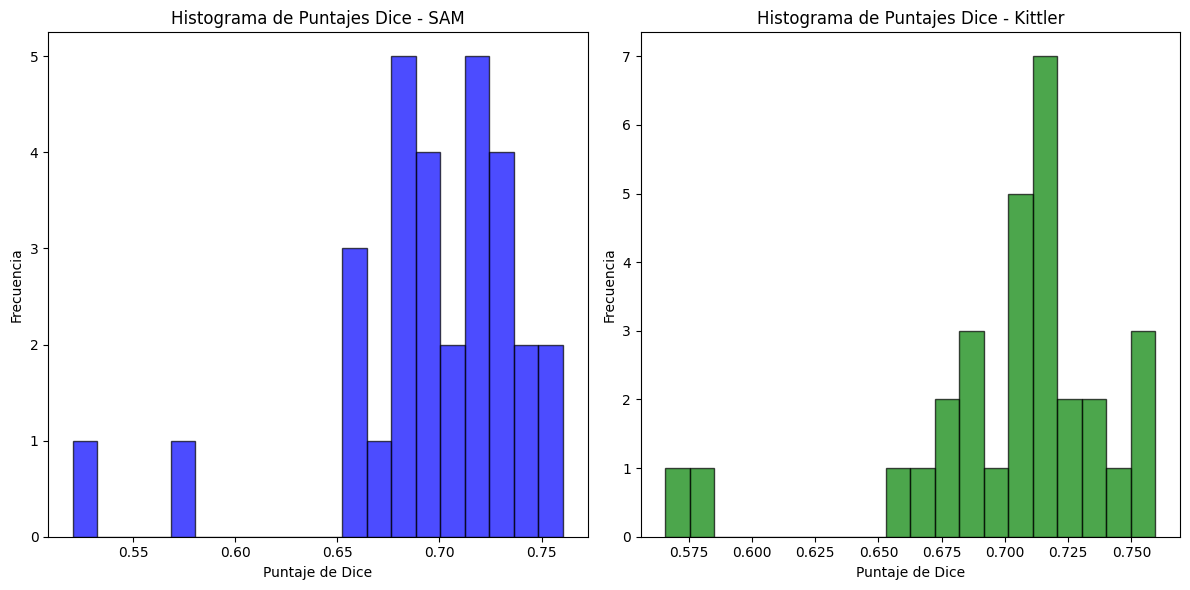

In [ ]:
num_bins = 20
frequencies_sam, bins_sam = np.histogram(dice_sam, bins=num_bins)

frequencies_kittler, bins_kittler = np.histogram(dice_kittler, bins=num_bins)

plt.figure(figsize=(12,6))

# Graficando histograma de SAM
plt.subplot(1, 2, 1)
plt.bar(bins_sam[:-1], frequencies_sam, width=np.diff(bins_sam), edgecolor="black", align="edge", color='blue', alpha=0.7)
plt.title("Histograma de Puntajes Dice - SAM")
plt.xlabel("Puntaje de Dice")
plt.ylabel("Frecuencia")

# Graficando histograma de Kittler
plt.subplot(1, 2, 2)
plt.bar(bins_kittler[:-1], frequencies_kittler, width=np.diff(bins_kittler), edgecolor="black", align="edge", color='green', alpha=0.7)
plt.title("Histograma de Puntajes Dice - Kittler")
plt.xlabel("Puntaje de Dice")
plt.ylabel("Frecuencia")

plt.tight_layout()

plt.savefig('histogramas_dice.png', dpi=300)
files.download('histogramas_dice.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

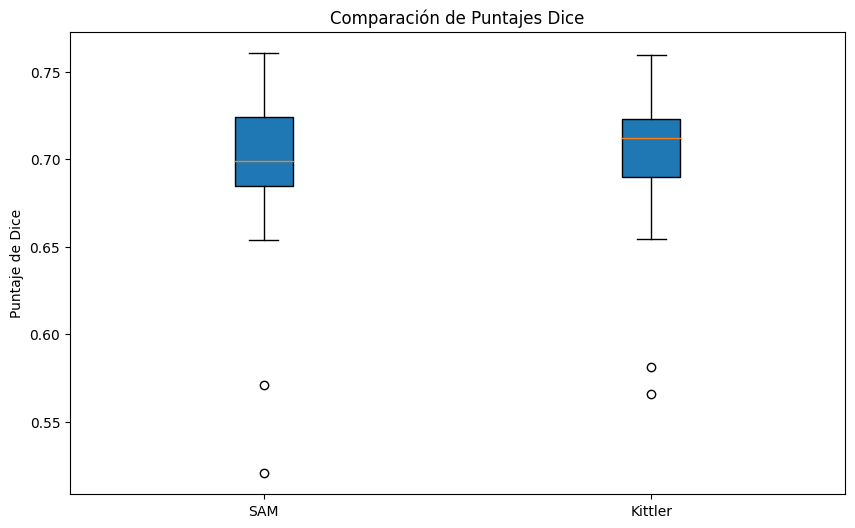

In [ ]:
data = [dice_sam, dice_kittler]

# Crear un boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data, vert=True, patch_artist=True, labels=['SAM', 'Kittler'])
plt.title('Comparación de Puntajes Dice')
plt.ylabel('Puntaje de Dice')

# Guardar el gráfico en una imagen
file_name = "box_plot.png"
plt.savefig(file_name)

# Descargar la imagen
files.download(file_name)

plt.show()







<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

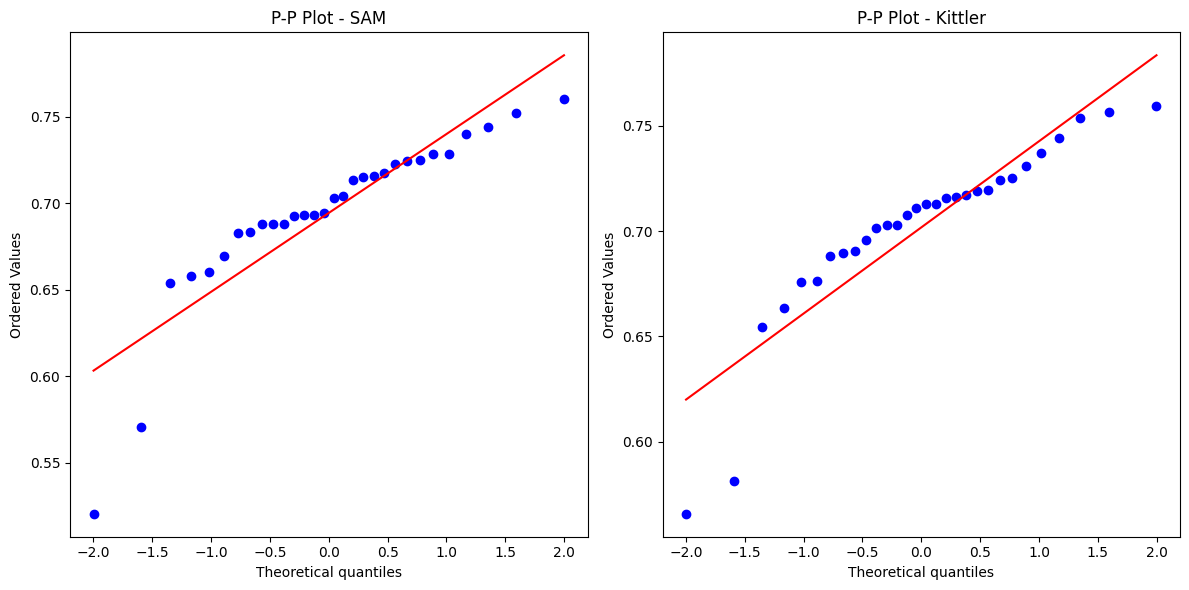

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
stats.probplot(dice_sam, plot=plt)
plt.title('P-P Plot - SAM')

# Crear un p-p plot para Kittler
plt.subplot(1, 2, 2)
stats.probplot(dice_kittler, plot=plt)
plt.title('P-P Plot - Kittler')

# Guardar el gráfico en una imagen
file_name = "pp_plot.png"
plt.tight_layout()
plt.savefig(file_name)

# Descargar la imagen
files.download(file_name)

plt.show()

# Prueba Kolmogorov-Smirnov y Jarque-Bera

In [9]:
# Se cargan los datos obtenidos

data = [
    [1, 0.694371, 0.675576],
    [2, 0.693059, 0.703058],
    [3, 0.660477, 0.67644],
    [4, 0.688064, 0.701478],
    [5, 0.682801, 0.702788],
    [6, 0.669525, 0.663236],
    [7, 0.724576, 0.712842],
    [8, 0.570872, 0.581286],
    [9, 0.71347, 0.718948],
    [10, 0.65389, 0.654639],
    [11, 0.752402, 0.688062],
    [12, 0.688185, 0.717254],
    [13, 0.703395, 0.725251],
    [14, 0.692903, 0.695933],
    [15, 0.739955, 0.744255],
    [16, 0.744122, 0.71283],
    [17, 0.728762, 0.756573],
    [18, 0.693567, 0.724279],
    [19, 0.715176, 0.707666],
    [20, 0.520495, 0.565657],
    [21, 0.70444, 0.719686],
    [22, 0.687995, 0.715821],
    [23, 0.722573, 0.690402],
    [24, 0.725309, 0.759536],
    [25, 0.68356, 0.716239],
    [26, 0.71574, 0.730943],
    [27, 0.760503, 0.737011],
    [28, 0.658282, 0.689345],
    [29, 0.728862, 0.753578],
    [30, 0.717383, 0.71102]
]

data = np.array(data)
dice_sam = data[:, 1]
dice_kittler = data[:, 2]

In [10]:
d_sam, p_value_sam = kstest(dice_sam, 'norm')
print(f"D-statistic: {d_sam}")
print(f"P-value: {p_value_sam}")

if( p_value_sam < 0.05):
  print("Se rechaza que la distribucion de los puntajes de dice de kittler sigue una distribucion normal")
else:
  print("Se acepta que los puntajes de dice de kittler sigue una distribucion normal")

d_kittler, p_value_kittler = kstest(dice_kittler, 'norm')
print(f"D-statistic: {d_kittler}")
print(f"P-value: {p_value_kittler}")


if( p_value_sam < 0.05):
  print("Se rechaza que la distribucion de los puntajes de dice de SAM sigue una distribucion normal")
else:
  print("Se acepta que los puntajes de dice de SAM sigue una distribucion normal")


D-statistic: 0.6986406940404728
P-value: 3.4299793552150473e-15
Se rechaza que la distribucion de los puntajes de dice de kittler sigue una distribucion normal
D-statistic: 0.7141865142083031
P-value: 5.482741155338835e-16
Se rechaza que la distribucion de los puntajes de dice de SAM sigue una distribucion normal


In [11]:
jb_sam, p_value_jb_sam = jarque_bera(dice_sam)
print(f"JB-statistic: {jb_sam}")
print(f"P-value: {p_value_jb_sam}")

if( p_value_jb_sam < 0.05):
  print("Se rechaza que la distribucion de los puntajes de dice de kittler sigue una distribucion normal")
else:
  print("Se acepta que los puntajes de dice de kittler sigue una distribucion normal")

jb_kittler, p_value_jb_kittler = jarque_bera(dice_kittler)
print(f"JB-statistic: {jb_kittler}")
print(f"P-value: {p_value_jb_kittler}")

if( p_value_jb_kittler < 0.05):
  print("Se rechaza que la distribucion de los puntajes de dice de SAM sigue una distribucion normal")
else:
  print("Se acepta que los puntajes de dice de SAM sigue una distribucion normal")

JB-statistic: 42.32406783146757
P-value: 6.448303121171765e-10
Se rechaza que la distribucion de los puntajes de dice de kittler sigue una distribucion normal
JB-statistic: 25.28167824177872
P-value: 3.2370791848859293e-06
Se rechaza que la distribucion de los puntajes de dice de SAM sigue una distribucion normal


In [12]:
leve_stat, p_value_leve = levene(dice_kittler, dice_sam)

print(f"t-paired-statistic: {leve_stat}")
print(f"P-value: {p_value_leve}")

if p_value_leve < 0.05:
    print("Las varianzas son significativamente diferentes, se rechaza la hipótesis nula de homocedasticidad.")
else:
    print("No hay evidencia suficiente para rechazar la hipótesis nula de homocedasticidad.")

t-paired-statistic: 0.18939983974099892
P-value: 0.6650318006724218
No hay evidencia suficiente para rechazar la hipótesis nula de homocedasticidad.


In [13]:
t_stat, p_value_t = ttest_rel(dice_kittler, dice_sam)
print("Ho: Los dos tratamientos estan pareados")

print(f"t-paired-statistic: {t_stat}")
print(f"P-value: {p_value_t}")

if( p_value_t < 0.05):
  print("Se rechaza la hipotesis los datos estan pareados")
else:
  print("Se acepta la hipotesis de que los datos estan pareados")



Ho: Los dos tratamientos estan pareados
t-paired-statistic: 1.635840517450083
P-value: 0.11268205884352891
Se acepta la hipotesis de que los datos estan pareados


In [14]:
w_stat, p_value_w = wilcoxon(dice_kittler, dice_sam)
print("Ho: No hay diferencia significativa entre los dos modelos")

print(f"w-paired-statistic: {w_stat}")
print(f"P-value: {p_value_w}")

if( p_value_w < 0.05):
  print("Se rechaza la hipotesis de que hay diferencia significativa entre ambos modelos")
else:
  print("Se acepta la hipotesis de que hay diferencia significativa entre ambos modelos")

Ho: No hay diferencia significativa entre los dos modelos
w-paired-statistic: 142.0
P-value: 0.0635564886033535
Se acepta la hipotesis de que hay diferencia significativa entre ambos modelos
